### Prerequisites:

 - We will use [pandas](https://pandas.pydata.org/docs/) for data processing,
 - and Meta's open-source LLM [Llama 3.1](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct) for prompting and few-shot learning.
- All experiments will be performed on the [arXiv Dataset](https://www.kaggle.com/datasets/Cornell-University/arxiv/code).

In [1]:
%%capture
# install dependecies:
!pip install numpy torch pandas scikit-learn transformers tqdm kagglehub

### Data processing

In [131]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "arxiv-metadata-oai-snapshot.json"

data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "Cornell-University/arxiv",
  file_path,
  pandas_kwargs={"lines": True}  
)
data['category'] = data['categories'].str.split().str[0]
data = data.sample(50000, random_state=42)  

data.sample()

/tmp/ipykernel_1804109/144700196.py:6: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  data = kagglehub.load_dataset(


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,category
1511534,2108.02719,Sam Raskin,"Joakim Faergeman, Sam Raskin",The Arinkin-Gaitsgory temperedness conjecture,None,None,None,None,math.AG math.RT,http://creativecommons.org/licenses/by/4.0/,Arinkin and Gaitsgory defined a category of ...,"[{'version': 'v1', 'created': 'Thu, 5 Aug 2021...",2021-08-06,"[[Faergeman, Joakim, ], [Raskin, Sam, ]]",math.AG


We use the `category` from the `title` of the scientific article as the target label to predict:

In [134]:
# select input and label from data:
X = data['title'].to_numpy()
y = data['category'].to_numpy()

In [135]:
# find the most 10 frequent classes and keep only those:
from collections import Counter

counter = Counter(y)
most_common_classes = [cls for cls, count in counter.most_common(10)]
print('Most common classes: ', most_common_classes) 

idxs = [i for i, label in enumerate(y) if label not in most_common_classes]
X = [x for i, x in enumerate(X) if i not in idxs]
y = [label for i, label in enumerate(y) if i not in idxs]

Most common classes:  ['hep-ph', 'cs.CV', 'quant-ph', 'hep-th', 'cs.LG', 'astro-ph', 'gr-qc', 'cs.CL', 'cond-mat.mtrl-sci', 'cond-mat.mes-hall']


In [136]:
from sklearn.model_selection import train_test_split

# create test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42, shuffle=True, stratify=y)
print('Size of test set : ', len(X_test))
print('Size of train set: ', len(X_train))
classes = set(y_train)
print('Classes: ', len(classes))

Size of test set :  1735
Size of train set:  15614
Classes:  10


In [137]:
# convert classes to integers:
classes_index = {cls: str(i) for i, cls in enumerate(classes)}
classes = [str(i) for i in range(len(classes))]
y_train = [classes_index[label] for label in y_train]
y_test = [classes_index[label] for label in y_test]

### Random Example Fetcher

In [138]:
import numpy as np

def fetch_random_train_vectors(train_vectors, k=1, seed=None):
    """
    Randomly select k indices from the training set.

    Args:
        train_vectors: A matrix or array representing training data (used only to determine size).
        k: Number of random indices to select.
        seed: Optional random seed for reproducibility.

    Returns:
        A list of k random indices from the training set.
    """
    if seed is not None:
        np.random.seed(seed)
        
    n = len(train_vectors)
    return np.random.choice(n, size=k, replace=False)

### Sparse Frquency-based Embeddings for Similarity

We import TfidfVectorizer from `sklearn.feature_extraction.text` and use it to create and fit a TF-IDF input embedding on the `X_train` data. Since `TfidfVectorizer.transform(...)` returns a sparse matrix.

In [139]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create and train input embedding:
tfidf = TfidfVectorizer().fit(X_train)

In [140]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def fetch_most_similar_train_vectors(test_vector, train_vectors, k=1):
    """
    For a given test TF-IDF vector, find the k most similar train TF-IDF vectors
    using cosine similarity.

    Args:
        test_vector: The TF-IDF vector for a single test instance.
        train_vectors: A sparse matrix of TF-IDF vectors for the training set.
        k: The number of most similar vectors to return.

    Returns:
        A list of indices of the k most similar train vectors.
    """
    # Calculate cosine similarity between the test vector and all train vectors
    # Reshape test_vector to be a 2D array for cosine_similarity
    similarities = cosine_similarity(test_vector.reshape(1, -1), train_vectors)

    # Get the indices of the top k most similar vectors
    # Use argsort to get indices in ascending order, then slice the last k
    # Flatten similarities to a 1D array for argsort
    most_similar_indices = np.argsort(similarities.flatten())[-k:]

    return most_similar_indices[::-1] # Return indices in descending order of similarity

In [141]:
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

t = X_test_tfidf[0] # test text
n = 3 # shots
similar_indices = fetch_most_similar_train_vectors(t, X_train_tfidf, k=n)
print(f"Most similar train indices for the first test sample\n'{X_test[0]}' (n={n}):{similar_indices}\n")
for i, idx in enumerate(similar_indices): print(i+1, X_train[idx])

Most similar train indices for the first test sample
'WINHAC - the Monte Carlo event generator for single W-boson production
  in hadronic collisions' (n=3):[12952 12971  4632]

1 Recent developments in Monte-Carlo Event Generators
2 Non-linear Quantum Monte Carlo
3 Comparison of hybrid and pure Monte Carlo shower generators on an event
  by event basis


### Instantiate Llama

In order to be able to use huggingface's Llama 3.1 models, we first need to log in to huggingface (you can request access to the model [here](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct)).

In [14]:
import getpass
from huggingface_hub import login
login(getpass.getpass('Enter your huggingface API-key:'))

In this tutorial we will use the standard huggingface textgeneration pipeline (compressed to 16 bit floating point weights) for the instruction tuned 8B parameter version of Llama 3.1.

In [104]:
%%capture
import transformers
import torch

# create llm pipeline:
llm = transformers.pipeline(
    "text-generation",
    model="meta-llama/Meta-Llama-3.1-8B-Instruct",
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto"
)

# Get special tokens for later:
bos_token_id = llm.tokenizer.convert_tokens_to_ids('<|begin_of_text|>')
eos_token_id = llm.tokenizer.convert_tokens_to_ids('<|eot_id|>')
pad_token_id = llm.tokenizer.convert_tokens_to_ids('<|eot_id|>')

### Few-shot learning with Random Examples

Generate a prompt for classification using a given text and $n$ labeled examples.


In [147]:
def get_prompt(text, shots):
    prompt = 'We classify scientific article labels from texts, as in the following examples:\n'
    for x,y in shots: prompt += f'\n"{x}": {y}'
    return {"role": "user", "content": f'{prompt}\n\nThe valid labels are: {", ".join(classes)}.\nPredict the correct label for the following text, but generate only the label and no other text.\n\n"{text}": '}

shots_idxs = fetch_random_train_vectors(X_train, k=n, seed=42)
shots = [(X_train[idx], y_train[idx]) for idx in shots_idxs]
prompt = get_prompt(X_test[0], shots)["content"]
print(prompt)

We classify scientific article labels from texts, as in the following examples:

"Implication of nano-Hertz stochastic gravitational wave background on
  ultralight axion particles": 3
"Weak Lensing by Galaxies in Groups and Clusters: I.--Theoretical
  Expectations": 9
"Large Language Models and Emergence: A Complex Systems Perspective": 6

The valid labels are: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9.
Predict the correct label for the following text, but generate only the label and no other text.

"WINHAC - the Monte Carlo event generator for single W-boson production
  in hadronic collisions": 


In [148]:
from tqdm import tqdm

def few_shot_learning_batch(test, test_tfidf, train, train_tfidf, y_train, n=3):
  outputs = []
  for i,t in tqdm(enumerate(X_test_tfidf), total=len(test)):
      shots_idxs = fetch_random_train_vectors(train, k=n, seed=42) 
      shots = [(train[idx], y_train[idx]) for idx in shots_idxs]
      prompt = get_prompt(test[i], shots)["content"]
      response = llm([prompt],
                    bos_token_id=bos_token_id,
                    eos_token_id=eos_token_id,
                    pad_token_id=pad_token_id,
                    max_new_tokens=1,
                    do_sample=False,
                    temperature=None,
                    top_p=None)
      label = response[0][0]["generated_text"].split(':')[-1].strip()
      outputs.append(label)
  return outputs

predictions = few_shot_learning_batch(X_test, X_test_tfidf, X_train, X_train_tfidf, y_train, n=3)

100%|██████████| 1735/1735 [02:20<00:00, 12.33it/s]


In [149]:
predictions[:10]

['7', '5', '0', '7', '7', '0', '7', '?', '3', '6']

Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.06      0.07       118
           1       0.00      0.00      0.00       117
           2       0.10      0.01      0.01       199
           3       0.27      0.20      0.23       245
           4       0.15      0.02      0.03       124
           5       0.17      0.17      0.17       225
           6       0.21      0.65      0.32       123
           7       0.07      0.20      0.10       196
           8       0.14      0.00      0.01       220
           9       0.41      0.58      0.48       168
        othe       0.00      0.00      0.00         0

    accuracy                           0.18      1735
   macro avg       0.15      0.17      0.13      1735
weighted avg       0.17      0.18      0.14      1735

Accuracy: 0.18213256484149856


Text(0.5, 1.0, 'Confusion Matrix')

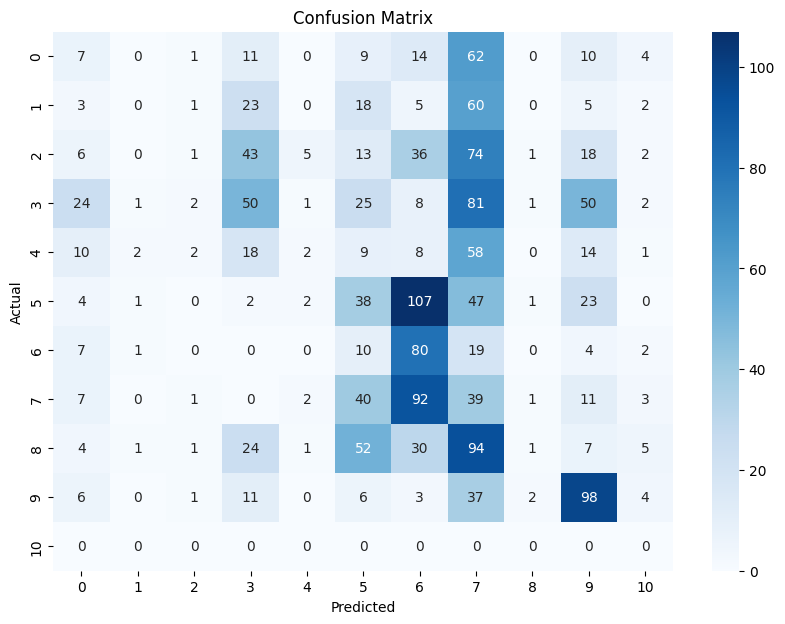

In [150]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def clean(labels, classes=classes, lim=4):
  labels = [lbl if lbl in classes else 'other' for lbl in labels]
  labels_short = [lbl[:lim] for lbl in labels]
  return labels_short

print("Classification Report:\n", classification_report(clean(y_test), clean(predictions), zero_division=0))
print("Accuracy:", accuracy_score(clean(y_test), clean(predictions)))

# Plot confusion matrix
cm = confusion_matrix(clean(y_test), clean(predictions))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

### Few-shot learning with Most Similar Examples

Generate a prompt for classification using a given text and $n$ labeled examples.

In [152]:
def get_prompt(text, shots):
    prompt = 'We classify scientific article labels from texts, as in the following examples:\n'
    for x,y in shots: prompt += f'\n"{x}": {y}'
    return {"role": "user", "content": f'{prompt}\n\nThe valid labels are: {", ".join(classes)}.\nPredict the correct label for the following text, but generate only the label and no other text.\n\n"{text}": '}

shots_idxs = fetch_most_similar_train_vectors(X_test_tfidf[0], X_train_tfidf, k=n)
shots = [(X_train[idx], y_train[idx]) for idx in shots_idxs]
prompt = get_prompt(X_test[0], shots)["content"]
print(prompt)

We classify scientific article labels from texts, as in the following examples:

"Recent developments in Monte-Carlo Event Generators": 3
"Non-linear Quantum Monte Carlo": 8
"Comparison of hybrid and pure Monte Carlo shower generators on an event
  by event basis": 9

The valid labels are: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9.
Predict the correct label for the following text, but generate only the label and no other text.

"WINHAC - the Monte Carlo event generator for single W-boson production
  in hadronic collisions": 


In [153]:
from tqdm import tqdm

def few_shot_learning_batch(test, test_tfidf, train, train_tfidf, y_train, n=3):
  outputs = []
  for i,t in tqdm(enumerate(X_test_tfidf), total=len(test)):
      shots_idxs = fetch_most_similar_train_vectors(t, train_tfidf, k=n)
      shots = [(train[idx], y_train[idx]) for idx in shots_idxs]
      prompt = get_prompt(test[i], shots)["content"]
      response = llm([prompt],
                    bos_token_id=bos_token_id,
                    eos_token_id=eos_token_id,
                    pad_token_id=pad_token_id,
                    max_new_tokens=1,
                    do_sample=False,
                    temperature=None,
                    top_p=None)
      label = response[0][0]["generated_text"].split(':')[-1].strip()
      outputs.append(label)
  return outputs

predictions = few_shot_learning_batch(X_test, X_test_tfidf, X_train, X_train_tfidf, y_train, n=3)

100%|██████████| 1735/1735 [02:24<00:00, 12.01it/s]


Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.42      0.41       118
           1       0.43      0.44      0.43       117
           2       0.60      0.41      0.49       199
           3       0.85      0.62      0.72       245
           4       0.60      0.32      0.42       124
           5       0.71      0.58      0.64       225
           6       0.76      0.58      0.65       123
           7       0.47      0.59      0.52       196
           8       0.57      0.67      0.61       220
           9       0.61      0.70      0.65       168
        othe       0.00      0.00      0.00         0

    accuracy                           0.55      1735
   macro avg       0.54      0.49      0.50      1735
weighted avg       0.62      0.55      0.57      1735

Accuracy: 0.5521613832853026


Text(0.5, 1.0, 'Confusion Matrix')

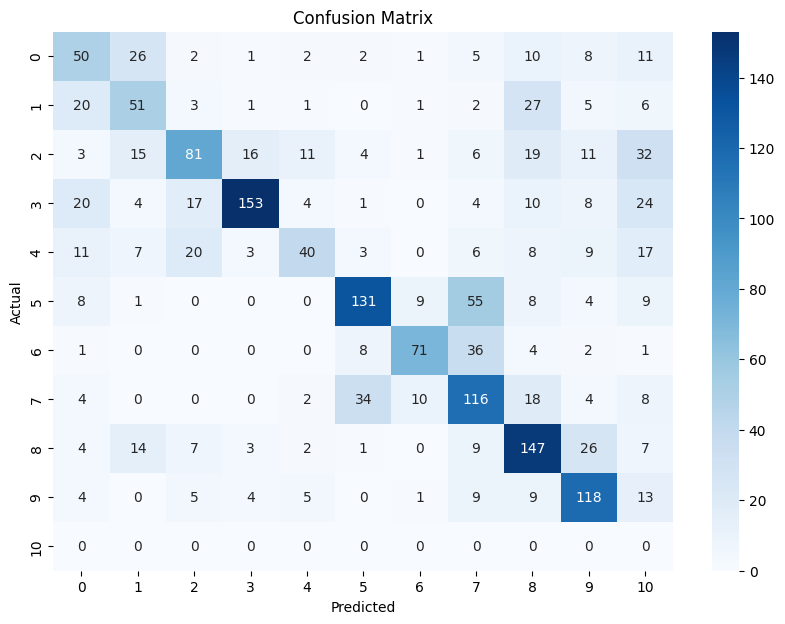

In [154]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def clean(labels, classes=classes, lim=4):
  labels = [lbl if lbl in classes else 'other' for lbl in labels]
  labels_short = [lbl[:lim] for lbl in labels]
  return labels_short

print("Classification Report:\n", classification_report(clean(y_test), clean(predictions), zero_division=0))
print("Accuracy:", accuracy_score(clean(y_test), clean(predictions)))

# Plot confusion matrix
cm = confusion_matrix(clean(y_test), clean(predictions))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')